<h3> Twitter Sentiment Analysis

<h5> Load Data

In [135]:
import pandas as pd 
import numpy as np

import tensorflow as tf

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [137]:
filepath_train = r"..\data\twitter_training.csv"
filepath_val = r"..\data\twitter_validation.csv"

train = pd.read_csv(filepath_train)
val = pd.read_csv(filepath_val)

In [138]:
train.head()

,id,games,impression,tweets
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [139]:
val.head()

,id,games,impression,tweets
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


<h5> EDA

In [140]:
train.duplicated().sum()

np.int64(2701)

In [141]:
train.isna().sum()

id              0
games           0
impression      0
tweets        686
dtype: int64

In [142]:
train.dropna(inplace=True)

In [143]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73996 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          73996 non-null  int64 
 1   games       73996 non-null  object
 2   impression  73996 non-null  object
 3   tweets      73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [144]:
train['impression'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [145]:
df_train = train[train['impression'] != 'Irrelevant']

In [146]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61121 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          61121 non-null  int64 
 1   games       61121 non-null  object
 2   impression  61121 non-null  object
 3   tweets      61121 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [147]:
df_train.shape

(61121, 4)

<Axes: xlabel='impression'>

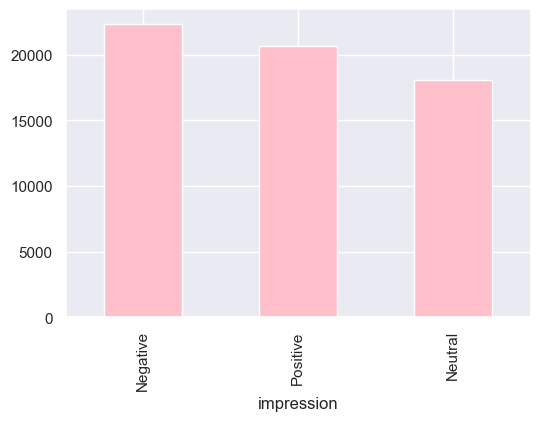

In [148]:
df_train['impression'].value_counts().plot.bar(color = 'pink', figsize = (6, 4))

<h6> we have sufficient number of entries for all the classes and the class imbalance is not extreme as in case of other problems like fraud transaction, etc. lets check the length of texts distribution for the different classes.

<h5> Data Preprocessing

In [149]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [150]:
import contractions
import re
import emoji
from bs4 import BeautifulSoup

In [151]:
def basic_cleaning(text):
    ''' 
        perform preprocessing of text to standardize the vocabulary
        return type: str
    '''

    text = emoji.demojize(text) 
    text = BeautifulSoup(text, 'html.parser').get_text() 
    text = contractions.fix(text) 
    text = text.lower() 
    text = re.sub(r"(.)\1{2,}", r"\1\1", text) 
    text = re.sub(r"[@#^<>|(){}[\]\~*+=]", " ", text) 
    text = re.sub(r"\s+", " ", text) 
    
    return text.strip()

def check_for_space_punc_only(text):
    '''
        check if the text has only punctuations or only spaces or not.
        return type: bool
    '''
    if not text or text.isspace():
        return True
    doc = nlp(text)
    if all(token.is_punct for token in doc):
        return True
    return False

def size_of_tweet(text):
    text = text.strip()
    words = text.split()
    return len(words)

In [152]:
df_train['tweets'] = df_train['tweets'].apply(basic_cleaning)
df_train['status'] = df_train['tweets'].apply(check_for_space_punc_only)

In [153]:
df_train.head()

,id,games,impression,tweets,status
0,2401,Borderlands,Positive,i am getting on borderlands and i will murder ...,False
1,2401,Borderlands,Positive,i am coming to the borders and i will kill you...,False
2,2401,Borderlands,Positive,i am getting on borderlands and i will kill yo...,False
3,2401,Borderlands,Positive,i am coming on borderlands and i will murder y...,False
4,2401,Borderlands,Positive,i am getting on borderlands 2 and i will murde...,False


In [154]:
df_train[df_train['status'] == True]

,id,games,impression,tweets,status
60,2411,Borderlands,Neutral,. .,True
62,2411,Borderlands,Neutral,..,True
64,2411,Borderlands,Neutral,..,True
353,2459,Borderlands,Positive,,True
588,2503,Borderlands,Neutral,. . . . . .,True
...,...,...,...,...,...
73931,9065,Nvidia,Negative,,True
73968,9073,Nvidia,Positive,,True
74418,9154,Nvidia,Positive,,True
74447,9161,Nvidia,Negative,,True


In [155]:
df_train.drop(df_train[df_train['status'] == True].index, inplace = True)

In [156]:
df_train['impression'].value_counts()

impression
Negative    22239
Positive    20542
Neutral     17977
Name: count, dtype: int64

In [157]:
df_train['tweet_length'] = df_train['tweets'].apply(size_of_tweet)

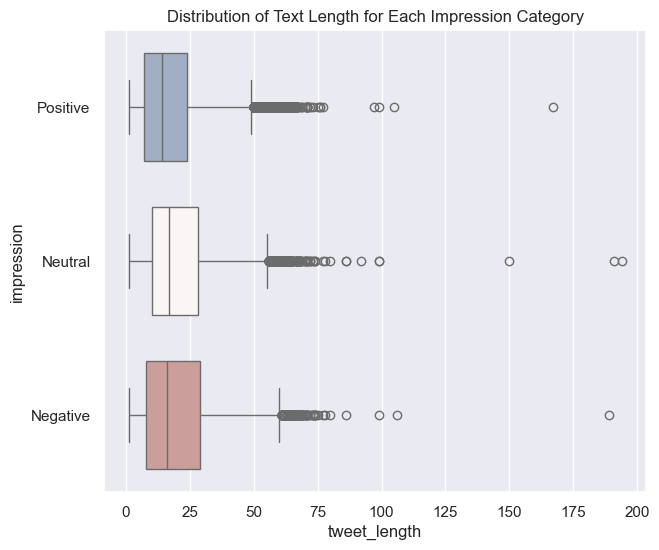

In [158]:
sns.set_theme(style = 'darkgrid')
f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(data=df_train, x='tweet_length', y='impression', width=.7, palette= "vlag")
plt.title('Distribution of Text Length for Each Impression Category')
ax.xaxis.grid(True)

<h6> apart from few of them which are very long the distribution is similar in all the classes. average tweet length is roughly the same regardless of whether the sentiment is positive, negative, or neutral

In [159]:
df_train.drop(columns=['id', 'status', 'tweet_length'], inplace=True)

In [160]:
df_train.drop_duplicates(inplace=True)

In [161]:
df_train.reset_index(drop=True, inplace=True)

In [162]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57187 entries, 0 to 57186
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   games       57187 non-null  object
 1   impression  57187 non-null  object
 2   tweets      57187 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


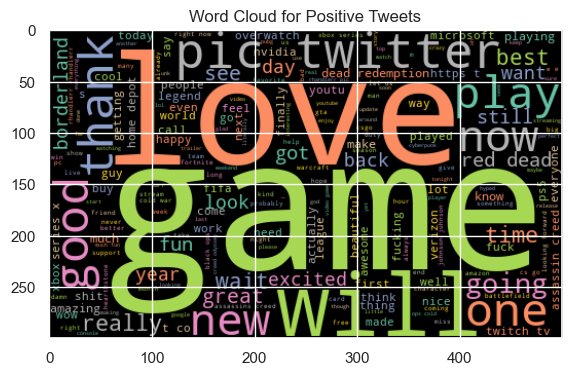

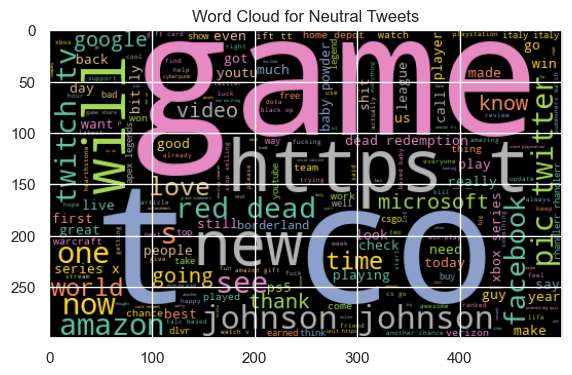

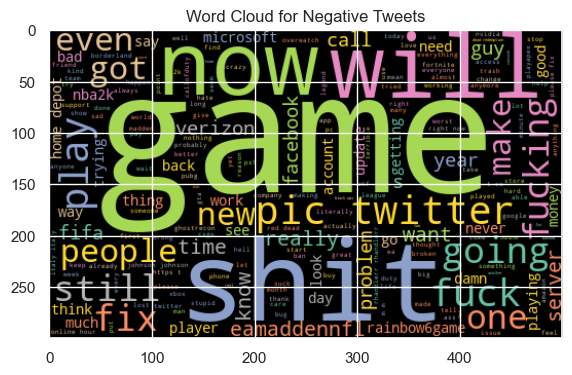

In [163]:
from wordcloud import WordCloud

def plot_wordcloud(sentiment_label):
    text = ' '.join(df_train[df_train['impression'] == sentiment_label]['tweets'].dropna())
    wordcloud = WordCloud(width=500, height=300, background_color='black', colormap='Set2').generate(text)

    plt.figure(figsize=(8,4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment_label} Tweets')
    plt.show()

for sentiment in df_train['impression'].unique():
    plot_wordcloud(sentiment)

<h5> Train Set

In [164]:
x=df_train.drop(columns=['impression'])
y=df_train['impression']

In [166]:
from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder() # Initialize LabelEncoder for converting categorical labels to numerical ones
y_lbl=lbl.fit_transform(y)

<h5> Test Set

In [167]:
x_test=val.drop(columns=['id', 'impression'])
y_test=val['impression']
y_test=lbl.fit_transform(y_test)

<h6> lemmitize the text and also for better context merge the game name col to the tweet.

In [169]:
def lem(text_col, cat_col, data):
    data[text_col]=data[cat_col].astype(str)+" "+data[text_col].astype(str) # Concatenate the 'games' column content with the 'tweets' column content
    lemm=[" ".join([token.lemma_ for token in doc]) for doc in nlp.pipe(data[text_col], batch_size=256, n_process=-1)] # Perform lemmatization using spaCy's nlp.pipe for efficient batch processing
    return pd.Series(lemm, index=data.index)

In [170]:
x['lemmatized']=lem('tweets', 'games', x.copy())

In [172]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW, RMSprop, SGD
from keras_tuner.tuners import RandomSearch
def token(text):
    tokenizer=Tokenizer(num_words=None, filters='"#&()*+-/:;<=>@[\\]^_`{|}~\t\n"', char_level=False, oov_token=None) # Initialize the Tokenizer
    tokenizer.fit_on_texts(text) # Fit the tokenizer on the text data to build the word index (vocabulary)
    word_index=tokenizer.word_index # Get the word-to-index mapping from the fitted tokenizer
    sequence=tokenizer.texts_to_sequences(text) # Convert text to sequences based on the learned word index
    vocab_size=len(word_index)+1 # Calculate the vocabulary size
    max_seq_len=max(len(seq) for seq in sequence) # Calculate the maximum sequence length among all sequences
    padded_seq=pad_sequences(sequence, maxlen=max_seq_len, padding='post') # Pad the sequences to the maximum length
    return padded_seq, max_seq_len, word_index, vocab_size

In [173]:
padding, max_len, word_index, vocab= token(x['lemmatized'])

In [174]:
padding

array([[ 51,   3,   2, ...,   0,   0,   0],
       [ 51,   3,   2, ...,   0,   0,   0],
       [ 51,   3,   2, ...,   0,   0,   0],
       ...,
       [ 44,  31, 940, ...,   0,   0,   0],
       [ 44,  31, 940, ...,   0,   0,   0],
       [ 44,  31,  40, ...,   0,   0,   0]],
      shape=(57187, 200), dtype=int32)

In [175]:
from sklearn.model_selection import train_test_split
x_tr, x_ts, y_tr, y_ts=train_test_split(padding, y_lbl, test_size=0.2, random_state=42)

In [176]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True, min_delta=0.001, verbose=3)

In [177]:
def bilstm(vocab_size, max_length, embedding_dim, units1, units2, activation, 
           recurrent_activation1, recurrent_activation2, optim, lr, dropout_rate1, dropout_rate2, l2_strength1, l2_strength2):
    model=Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, trainable=True))
    model.add(Bidirectional(LSTM(units1, activation=activation, return_sequences=True, 
                                 recurrent_activation=recurrent_activation1, kernel_regularizer=l2(l2_strength1))))
    model.add(Dropout(dropout_rate1))
    model.add(Bidirectional(LSTM(units2, activation='tanh', return_sequences=False, 
                                 recurrent_activation=recurrent_activation2, kernel_regularizer=l2(l2_strength2))))
    model.add(Dropout(dropout_rate2))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer=optim(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [178]:
from tensorflow.keras.optimizers import AdamW
bilstm_model=bilstm(vocab, max_len, 64, 64, 32, 'tanh', 'hard_sigmoid', 'sigmoid', AdamW, 0.0001, 0.3, 0.4, 0.0002, 0.0003)

In [180]:
from sklearn.utils import class_weight

class_weights=class_weight.compute_class_weight('balanced', classes=np.unique(y_lbl), y=y_lbl)
cw_dict=dict(enumerate(class_weights))
print("Class Weights:", cw_dict)

Class Weights: {0: np.float64(0.9062628759785744), 1: np.float64(1.1155391697877652), 2: np.float64(0.9998601276335344)}


In [181]:
training=bilstm_model.fit(x_tr, y_tr, epochs=30, batch_size=256, validation_split=0.2, class_weight=cw_dict, callbacks=[early_stopping], verbose=1)
training

Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.3626 - loss: 1.3245 - val_accuracy: 0.3941 - val_loss: 1.1990
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.3904 - loss: 1.1963 - val_accuracy: 0.5296 - val_loss: 1.1319
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.5382 - loss: 1.0539 - val_accuracy: 0.6042 - val_loss: 0.9462
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.6404 - loss: 0.9137 - val_accuracy: 0.6451 - val_loss: 0.8851
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.7082 - loss: 0.8128 - val_accuracy: 0.7043 - val_loss: 0.7801
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.7529 - loss: 0.7297 - val_accuracy: 0.7416 - val_loss: 0.7304
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.7937 - loss: 0.6504 - val_accuracy: 0.7447 - val_loss: 0.7084
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8200 - loss: 0.5949 - val_accu

In [182]:
bilstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 64)        │     1,607,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,145,230 (19.63 MB)

 Trainable params: 1,715,076 (6.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,430,154 (13.09 MB)

In [183]:
print("------Evaluationg the model------")
loss, accuracy=bilstm_model.evaluate(x_tr, y_tr, verbose=3) # Returns the loss and accuracy on the provided dataset
print(f"  Train loss: {loss}")
print(f"  Train accuracy: {accuracy}")

------Evaluationg the model------
  Train loss: 0.30805620551109314
  Train accuracy: 0.9157795906066895


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred_r=bilstm_model.predict(x_ts)
y_pred_classes=np.argmax(y_pred_r, axis=1) # Convert predicted probabilities to predicted class labels
class_names = lbl.classes_ # Get the original class names from the LabelEncoder for better readability in reports
print("\n Classification Report:")
print(classification_report(y_ts, y_pred_classes, labels=[0, 1, 2],target_names=class_names))
print("\n Confusion Matrix:")
print(confusion_matrix(y_ts, y_pred_classes))

NameError: name 'bilstm_model' is not defined

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_ts, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'y_ts' is not defined

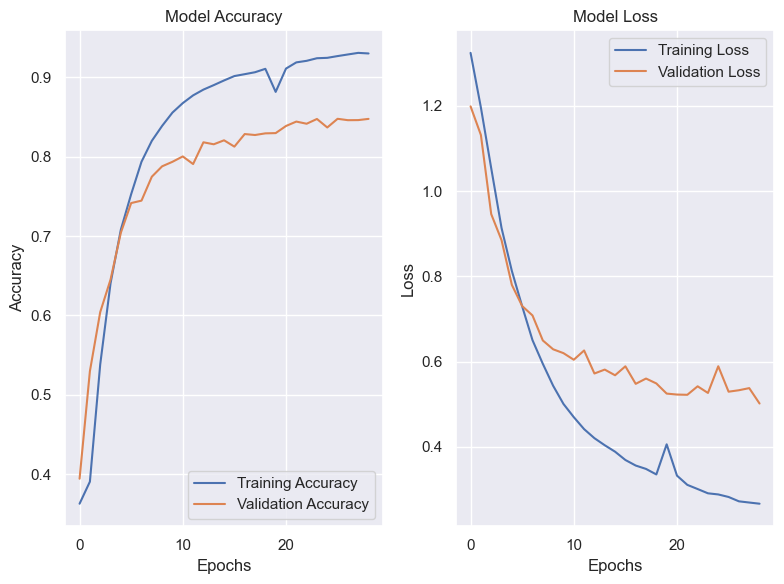

In [192]:
plt.figure(figsize=(8, 6))

plt.subplot(1, 2, 1)
plt.plot(training.history['accuracy'], label='Training Accuracy')
plt.plot(training.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(training.history['loss'], label='Training Loss')
plt.plot(training.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()